In [ ]:
#https://realpython.com/k-means-clustering-python/

In [ ]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [ ]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

In [ ]:
data[:5, :3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

In [ ]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

In [ ]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0])

In [ ]:
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

In [ ]:
n_clusters = len(label_encoder.classes_)
n_clusters

5

In [ ]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [ ]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [ ]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [ ]:
pipe.fit(data)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=5, n_init=50, n_jobs=None,
                                         precomp

In [ ]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [ ]:
#A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another,
#and a silhouette coefficient of 1 indicates clusters are well-separated.
#An ARI score of 0 indicates that cluster labels are randomly assigned,
#and an ARI score of 1 means that the true labels and predicted labels form identical clusters

silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450308

In [ ]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

In [ ]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


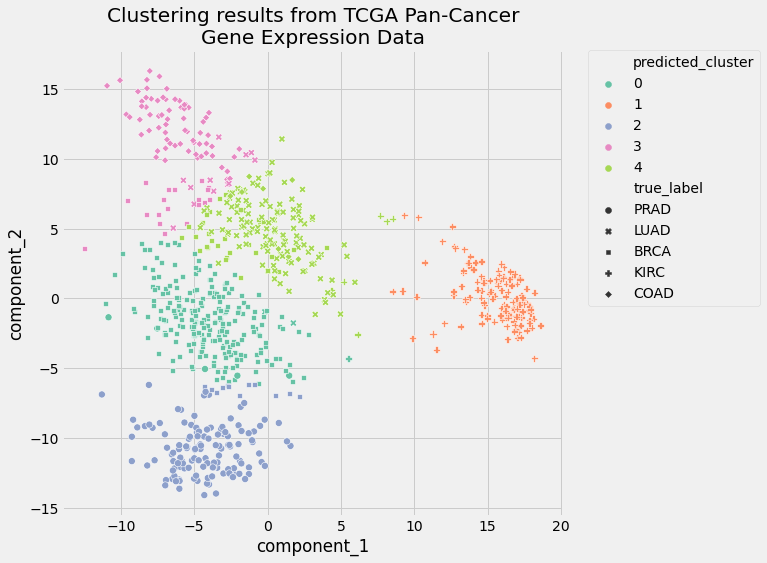

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [ ]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

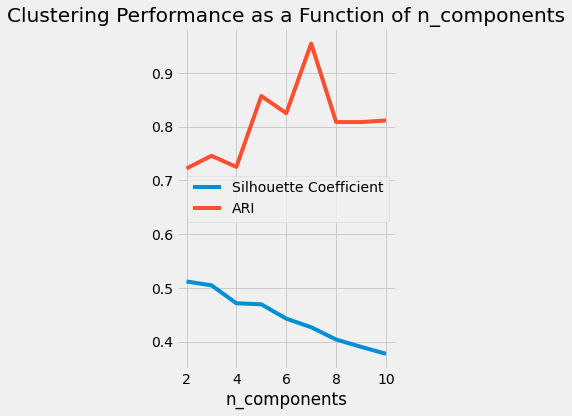

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()